In [110]:
import glob
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from tensorflow import keras

from sklearn.model_selection import train_test_split

In [111]:
instrument_Names = ['guitar']

In [112]:
train = []
target = []

In [113]:
for name in instrument_Names:
    for image in sorted(glob.glob('../../Data/%sresize/*.jpg'%name)):
        img = Image.open(image)
        img = img.convert('L')
        train.append(img)
        target.append(name)

In [114]:
number_of_data = len(train)
img_width_size = 100
img_height_size = 100

# train 만들기

In [115]:
train = np.zeros(number_of_data*img_width_size*img_height_size, dtype=np.int32).reshape(number_of_data, img_width_size, img_height_size)
i=0

for name in instrument_Names:
    for file in sorted(glob.glob('../../Data/%sresize/*.jpg'%name)):
        img = np.array(Image.open(file), dtype=np.int32)
        train[i,:,:] = img
        i+=1

In [116]:
train.shape

(15, 100, 100)

# target 만들기

In [117]:
target = np.concatenate([np.zeros(number_of_data)])
target

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# 정규화

In [118]:
train = train.reshape(-1, 100, 100, 1) / 255.0

# train,test 만들기

In [119]:
x_train, x_test, y_train, y_test = train_test_split(
    train, target, test_size=0.2
)

In [120]:
# trainData = np.zeros(len(x_train) * 100*100, dtype=np.int32).reshape(len(x_train), 100, 100)
# testData = np.zeros(len(x_test) * 100*100, dtype=np.int32).reshape(len(x_test), 100, 100)

In [121]:
# i = 0
# for image in x_train:
#     img = np.array(image, dtype=np.int32)
#     trainData[i,:,:] = img
#     i += 1

# i = 0
# for image in x_test:
#     img = np.array(image, dtype=np.int32)
#     testData[i,:,:] = img
#     i += 1

In [122]:
# print(trainData.shape)
# print(testData.shape)

In [123]:
# #data의 정규화
# trainData=trainData.astype('float32')/255
# testData=testData.astype('float32')/255

# trainData=trainData.reshape((len(trainData),100*100))
# testData=testData.reshape((len(testData),100*100))

In [124]:
# print(trainData.shape)
# print(testData.shape)

### Tensorflow Model 만들기

In [125]:
# MNIST Data를 입력으로
InputModel=keras.layers.Input(shape=(100,100,1))

noiseInput = keras.layers.GaussianNoise(stddev=0.2)(InputModel)

EncodedLayer = keras.layers.Conv2D(16, kernel_size = 3, activation='relu', padding='same',input_shape = (100, 100, 1))(noiseInput)
EncodedLayer = keras.layers.MaxPooling2D((2,2), padding='same')(EncodedLayer)

EncodedLayer = keras.layers.Conv2D(8, kernel_size = 3, activation='relu', padding='same',input_shape = (100, 100, 1))(noiseInput)
EncodedLayer = keras.layers.MaxPooling2D((2,2), padding='same')(EncodedLayer)

DecoderLayer = keras.layers.Conv2D(8, kernel_size = 3, activation='relu', padding='same',input_shape = (100, 100, 1))(EncodedLayer)
DecoderLayer = keras.layers.UpSampling2D((2, 2))(DecoderLayer)

DecoderLayer = keras.layers.Conv2D(16, kernel_size = 3, activation='relu', padding='same',input_shape = (100, 100, 1))(EncodedLayer)
DecoderLayer = keras.layers.UpSampling2D((2, 2))(DecoderLayer)


DecoderLayer = keras.layers.Conv2D(1, kernel_size = 3, activation='sigmoid', padding='same',input_shape = (100, 100, 1))(DecoderLayer)

# AutoEncoderModel은 입력값과 복원값을 최소화 하는 과정
AutoencoderModel=keras.models.Model(InputModel,DecoderLayer)

AutoencoderModel.compile(optimizer='adam',loss='binary_crossentropy')

In [126]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint('../../Note/Crawling/autoencoder_best.h5')

history=AutoencoderModel.fit(x_train,x_train,
                             batch_size=128, # 한번에 읽어들이는 데이터의 양. 작업 속도만 차이가 날 뿐 결과물은 차이가 없다.
                             epochs=2000,
                             shuffle=True,
                             validation_data=(x_test,x_test),
                             #callbacks=[checkpoint_cb,early_stopping_cb]
                             )

Epoch 1/2000
1/1 [==============================] - 1s 898ms/step - loss: 0.6435 - val_loss: 0.6482
Epoch 2/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.6314 - val_loss: 0.6373
Epoch 3/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.6178 - val_loss: 0.6260
Epoch 4/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.6034 - val_loss: 0.6139
Epoch 5/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.5879 - val_loss: 0.6013
Epoch 6/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.5719 - val_loss: 0.5876
Epoch 7/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.5552 - val_loss: 0.5735
Epoch 8/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.5383 - val_loss: 0.5591
Epoch 9/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.5213 - val_loss: 0.5446
Epoch 10/2000
1/1 [==============================] - 0s 93ms/step - loss: 0.5042 - val_loss: 0.5301
Epoch

In [127]:
DecodedDigits=AutoencoderModel.predict(x_test)

1/1 [==============================] - 0s 68ms/step


In [128]:
# testData와 DecodedDigits의 크기
print(x_test.shape)
print(DecodedDigits.shape)

(3, 100, 100, 1)
(3, 100, 100, 1)


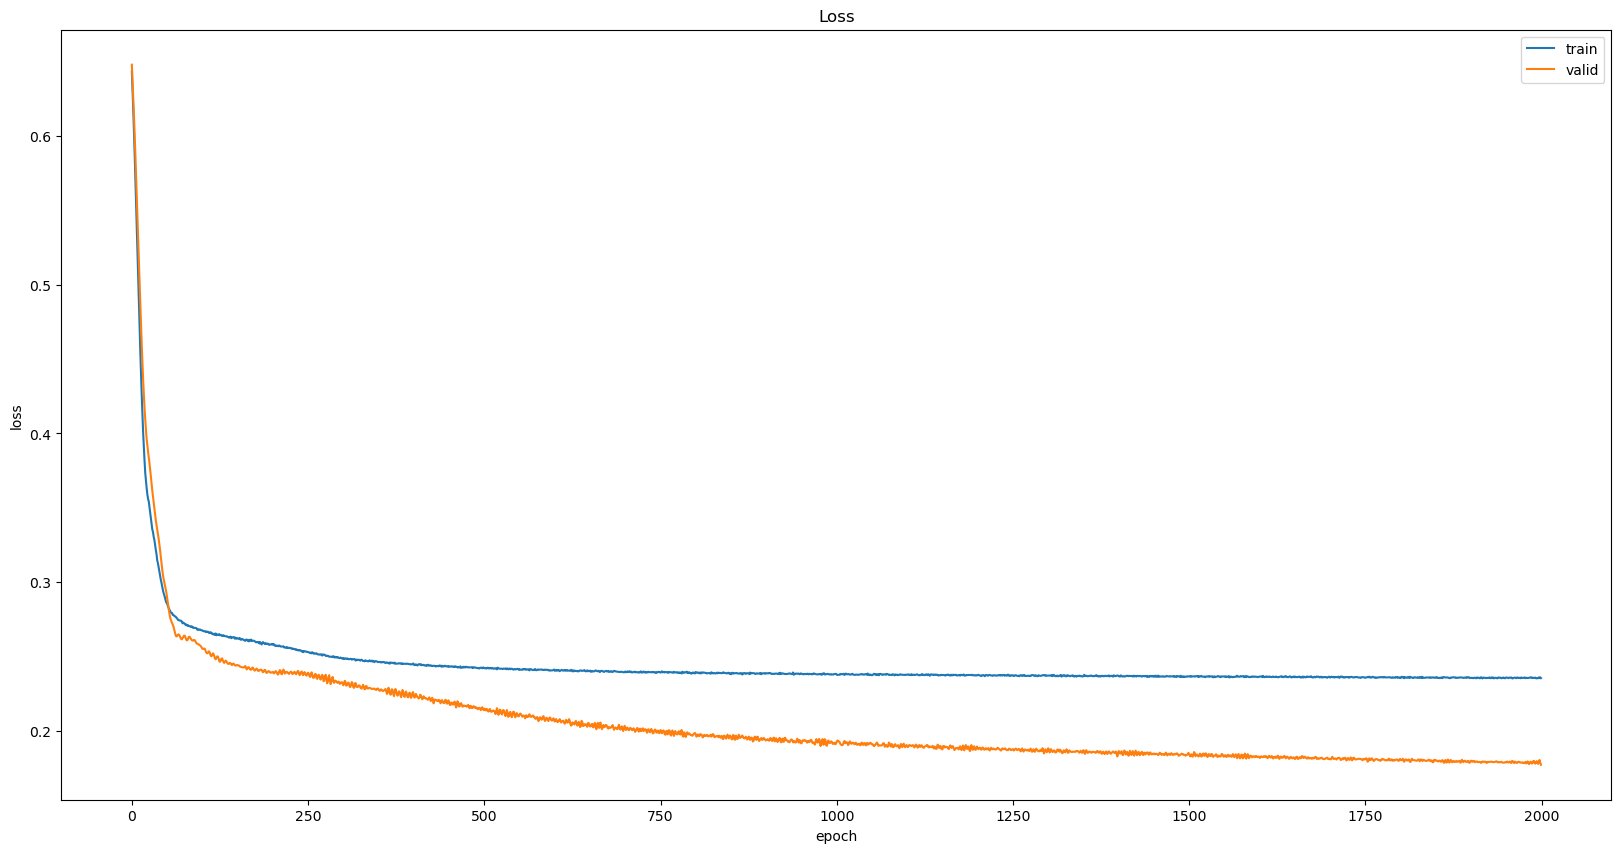

In [129]:
from chart import chart  # 팀원 유승님의 차트 시각화 모듈
chart(history, accuracy=False, figsize=(20,10))

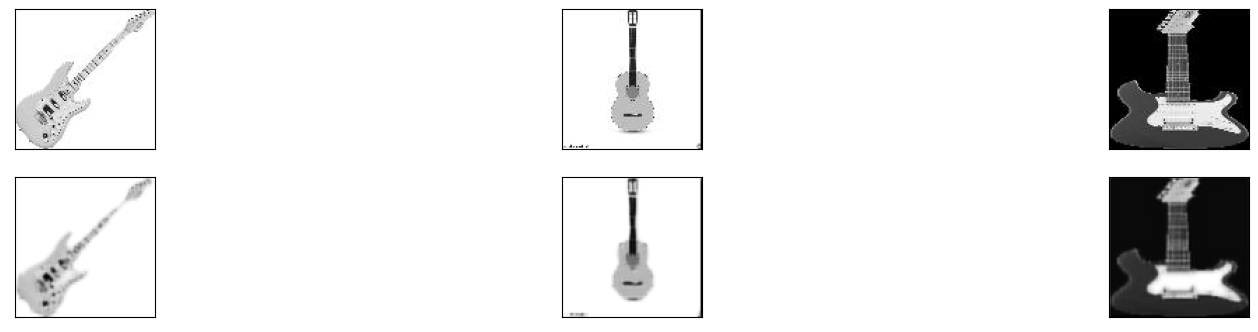

In [130]:
# test data 시각화
n=3
plt.figure(figsize=(20,4))
for i in range(n):
    ax=plt.subplot(2,n,i+1)
    plt.imshow(x_test[i].reshape(100,100))
    ax.get_xaxis().set_visible(False)#축 안보여주겠다.
    ax.get_yaxis().set_visible(False)#축 안보여주겠다.
    plt.gray()
    #-----------------
    ax=plt.subplot(2,n,i+1+n)
    plt.imshow(DecodedDigits[i].reshape(100,100))
    ax.get_xaxis().set_visible(False)#축 안보여주겠다.
    ax.get_yaxis().set_visible(False)#축 안보여주겠다.
    plt.gray()
plt.show()#위에가 원본 데이터 밑에가 압축되어 나온 데이터이다. data size가 줄어든 것을 확인할 수 있다.